In [2]:
from resources.workspace import *

/Users/pataan/Dropbox/DPhil/DAPPER
Initializing DAPPER...Done


# The Gaussian (i.e. Normal) distribution

Consider the random variable with a Gaussian distribution with mean $b$ (`b`) and variance $B$. We write its probability density function (**pdf**) as
$$ p(x) = N(x \mid b,B) = (2 \pi B)^{-1/2} e^{-(x-b)^2/2P} \, .  \qquad \qquad (G1) $$

**Exc 2.2:** Code it up (complete the code below)! Hints:
* Note that `**` is the power operator in Python.
* As in Matlab, $e^x$ is available as `exp(x)`

In [6]:
# Univariate (scalar), Gaussian pdf
def pdf_G1(x,b,B):
    # pdf_values = ### INSERT ANSWER HERE ###
    pdf_values = 1/sqrt(2*pi*B)*exp(-0.5*(x-b)**2/B)
    # Version using the scipy (sp) library:
    # pdf_values = sp.stats.norm.pdf(x,loc=b,scale=sqrt(B))
    return pdf_values

In [7]:
#show_answer('pdf_G1')


Let's plot the pdf.

<IPython.core.display.Javascript object>


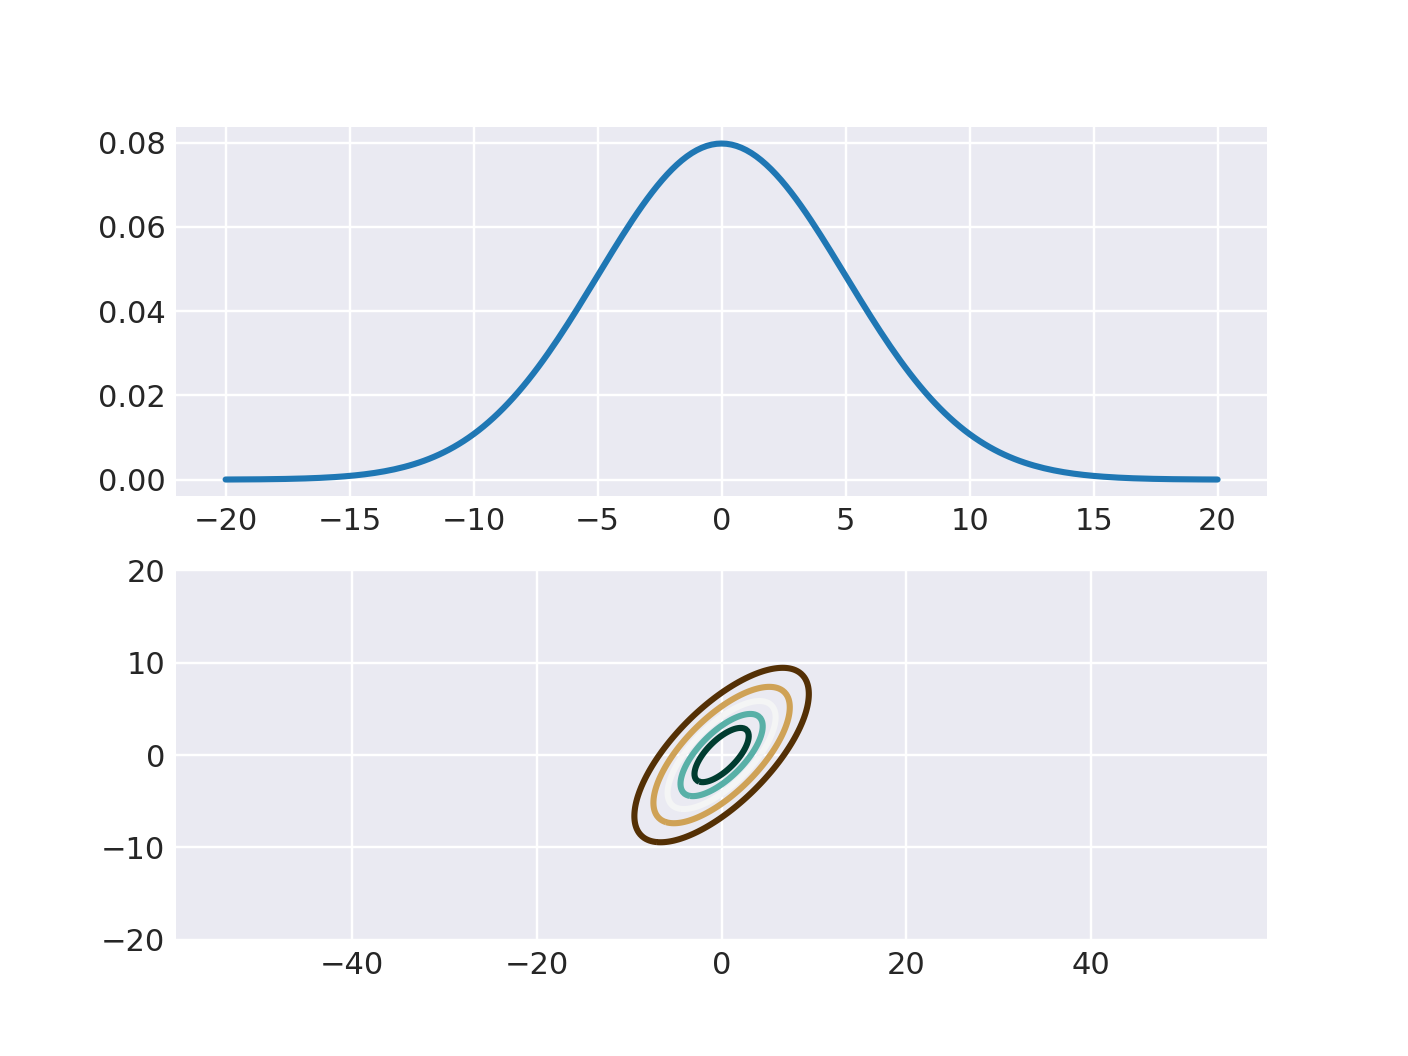

In [8]:
b  = 0                  # mean     of distribution
B  = 25                 # variance of distribution

# Plotting
N  = 201                # num of grid points
xx = linspace(-20,20,N) # grid
dx = xx[1]-xx[0]        # grid spacing
pp = pdf_G1(xx,b,B)     # pdf values
plt.subplot(211)        # allocate plot panel
plt.plot(xx,pp);        # plot

This could for example be the pdf of a stochastic noise variable. It could also describe our quantitative belief and uncertainty about a parameter (or state), which we model as randomness in the Bayesian view on probability.

**Exc 2.4:** From looking at the figure:
 * How does the pdf curve change when `b` changes?  
   (alter the above code, and re-run the cell)
 * How does the pdf curve change when you increase `B`?  
 
 
Re-set `B=25` and re-run (this is a convienient value for examples)

**Exc 2.6:** Recall $p(x) = N(x \mid b,B)$ from eqn (G1).  
The following are helpful points to remember how it looks. Use pen, paper, and calculus.  
Hint: it's usually easier to analyse $\log p(x)$ rather than $p(x)$ itself.
 * (a) Where is the location of the mode (maximum) of the distribution? I.e. where $\frac{d p}{d x}(x) = 0$.
 * (b) Where is the inflection point? I.e. where $\frac{d^2 p}{d x^2}(x) = 0$.
 * (c) Some forms of "sensitivy analysis" (a basic form of uncertainty quantification) consist in evaluating $\frac{d^2 p}{d x^2}(x)$ at the mode. Explain this by reference to the Gaussian shape.
Hint: calculate and interpret $\frac{d^2 p(x)}{d x^2}(b)$

### The multivariate (i.e. vector) case
Here's the pdf of the *multivariate* Gaussian:
\begin{align*}
N(x \mid  b,B) &= |2 \pi B|^{-1/2} \, \exp\Big(-\frac{1}{2}\|x-b\|^2_B\Big) \, , \qquad \qquad (GM) \\\
\end{align*}
where $|.|$ represents the determinant, and $\|.\|_W$ represents the norm with weighting: $\|x\|^2_W = x^T W^{-1} x$.  

The following implements this pdf. Take a moment to digest the code. But don't worry yet if you don't understand all of the details.

In [9]:
from numpy.linalg import det, inv

def weighted_norm22(xx,W):
    "Computes the norm of each row vector of xx, as weighted by W."
    ww = np.sum((xx @ inv(W)) * xx, axis=1)    # "vectorized" (fast) version
    #ww = array([ x @ inv(W) @ x for x in xx]) # "loop" version.
    return ww

def pdf_GM(xx,b,B):
    "pdf -- Gaussian, Multivariate: N(x|b,B)"
    return 1/sqrt(det(2*pi*B))*exp(-0.5*weighted_norm22(xx-b,B))

Tips:
 * `@` produces matrix multiplication (`*` in `Matlab`);
 * `*` produces array multiplication (`.*` in `Matlab`);
 * `axis=1` makes `np.sum()` work along the horizontal dimension of a 2D-array (matrix);
 * `axis=0` makes `np.sum()` work along the vertical dimension.

The following code plots the pdf as contour (equi-density) curves.  
*The plot appears in the above figure.*

In [10]:
# Grid
def flatten(xxyy): return array([xi.ravel() for xi in xxyy]).T
def  square(xyxy): return xyxy.reshape(int(sqrt(len(xyxy))),-1)

grid = flatten(np.meshgrid(xx,xx))

# Covariance specification
corr = 0.7
Cov = B * array([[1,corr],
                 [corr,1]])
# Eval
pp = pdf_GM(grid, 0, Cov)
pp = square(pp)

# Plot
plt.subplot(212).clear()
plt.contour(xx,xx,pp)
plt.axis('equal');

**Exc 2.8:** How do the contours look? Try to understand why. Cases:
 * (a) correlation=0.    
 * (b) correlation=0.99.
 * (c) correlation=0.5. (Note that we've used `plt.axis('equal')`).
 * (d) correlation=0.5, but with non-equal variances.

**Exc 2.9:** Go play the [correlation game](http://guessthecorrelation.com/)

# Bayes' rule
Bayes' rule is how we do inference. For continuous random variables, $x$ and $y$, it reads:

$$ p(x|y) = \frac{p(x) \, p(y|x)}{p(y)} \, , \qquad \qquad (2)$$

or, in words:


$$
\text{"posterior" (pdf of $x$ given $y$)}
\; = \;
\frac{\text{"prior" (pdf of $x$)}
\; \times \;
\text{"likelihood" (pdf of $y$ given $x$)}}
{\text{"normalization" (pdf of $y$)}} \, .
$$

**Example:** 
 - You believe the temperature $(x)$ in the room is $22°C \pm 2°C$;  
more specifically, your (prior) belief is described by: $p(x) = N(x \mid 22, 4)$.  
 - A thermometer yields the observation $y = 24°C \pm 2°C$;  
this yields the likelihood: $p(y|x) = N(24 \mid x, 4)$. 
 - Your updated belief is given by  $p(x) \, p(y|x)$,  
yielding the "posterior"/"analysis": $p(x|y) = N(x \mid 23, 2)$  
(exactly how these numbers are calculated will be shown below).

**Exc 2.10:** Derive Bayes' rule from the definition of [conditional pdf's](https://en.wikipedia.org/wiki/Conditional_probability#Kolmogorov_definition).

In [11]:
#show_answer('BR derivation')

**Exc 2.11*:** Laplace also independently (and more clearly) developed Bayes' rule, published in 1774. Some time therafter, the reasoning of "inverse probability" came to mean what we now call "statistical inference". Nowadays, "inverse problems" are often given a statistical interpretation. Considering this context, why do you think we use $x$ for the "unknown", and $y$ for the known (given) "data" ?

In [12]:
#show_answer('inverse')

Computers generally work with discrete, numerical representations of mathematical entities.
Numerically, pdfs may be represented by their `values` on a grid, such as `xx` from above. Bayes' rule (2) then consists of *grid-point-wise* multiplication, as shown below.

In [13]:
def Bayes_rule(prior_values,lklhd_values,dx):
    "Numerical (pointwise) implementation of Bayes' rule."
    pp = prior_values * lklhd_values   # pointwise multiplication
    posterior_values = pp/(sum(pp)*dx) # normalization
    return posterior_values

**Exc 2.12:** Why does `Bayes_rule()` not need the denominator, $p(y)$, as input?

In [14]:
#show_answer('BR normalization')

In fact, since normalization is so simple, we often don't bother to do it until we need it (for example, to compute the posterior mean; the formula $\mathbb{E}(x|y) = \int x \, p(x) \, dx \approx$ `x*pp*dx` is only valid if `pp` has been normalized.). Therefore we often simplify Bayes' rule (2) as
$$ p(x|y) \propto p(x) \, p(y|x) \, .  \qquad \qquad (3) $$

However, sometimes (e.g. non-parametric sampling methods), it is not so simple, and "how to  normalize" becomes an important question too.


The code below show's Bayes' rule in action.  
Again, remember that the only thing it's doing is multiplying the prior and likelihood at each gridpoint.  
Move the sliders with the arrow keys to animate it.

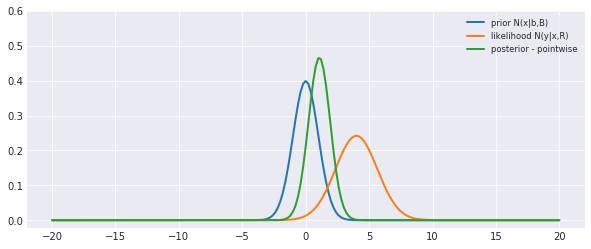

In [15]:
%matplotlib inline

# Fix the prior's parameters
b = 0 # mean
B = 1 # variance

@interact(y=(-10,10,1),log_R=(-2,5,0.5))
def animate_Bayes(y=4.0,log_R=1):

    R = exp(log_R)

    prior_vals = pdf_G1(xx,b,B)
    lklhd_vals = pdf_G1(y,xx,R)
    
    postr_vals = Bayes_rule(prior_vals, lklhd_vals, xx[1]-xx[0])

    plt.figure(figsize=(10,4))
    plt.plot(xx,prior_vals, label='prior N(x|b,B)')
    plt.plot(xx,lklhd_vals, label='likelihood N(y|x,R)')
    plt.plot(xx,postr_vals, label='posterior - pointwise')
    
    ### Uncomment this block AFTER doing the Exc 2.24 ###
    #mu, P = Bayes_rule_G1(b,B,y,R)
    #postr_vals2 = pdf_G1(xx,mu,P)
    #plt.plot(xx,postr_vals2,'--',label='posterior - parametric\n N(x|mu,P)')
    
    plt.ylim(ymax=0.6)
    plt.legend()
    plt.show()

**Exc 2.14:** Answer the following by moving the sliders and seeing what happens.
 * What happens to the posterior when $R \rightarrow \infty$ ?
 * What happens to the posterior when $R \rightarrow 0$ ?
 * Move around $y$. What is the posterior's location (mean/mode) when $R = B$ ?
 * Does the posterior scale (width) depend on $y$?
 * Consider the shape (ignoring location & scale) of the posterior. Does it depend on $R$ or $y$?
 * Can you see a shortcut to computing this posterior rather than having to do the pointwise multiplication?

**Exc 2.15*:** Implement a "uniform" (or "flat" or "box") distribution pdf and call it `pdf_U1(x,mu,P)`. These <a href="https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)#Moments">formulae</a> for its mean/variance will be useful. 

In the above animations, replace `pdf_G1` with your new `pdf_U1` (both for the prior and likelihood). Assure that everything is working correctly. 
 - Why (in the figure) are the walls of the pdf (ever so slightly) inclined?
 - What happens when you move the prior and likelihood too far apart? Is the fault of the implementation, or the math, or the assumptions (uniform distribution)?
 - Re-do Exc 2.14, now with `pdf_U1`.
 - Now test a Gaussian prior with a uniform likelihood.
 - Restore `pdf_G1` (both the prior and likelihood) in the animation (for later use).
 

In [18]:
#show_answer('pdf_U1')

In [17]:
def pdf_U1(x,b,B):
    # Univariate (scalar), Uniform pdf

    pdf_values = ones((x-b).shape)

    a = b - sqrt(3*B)
    b = b + sqrt(3*B)

    pdf_values[x<a] = 0
    pdf_values[x>b] = 0

    height = 1/(b-a)
    pdf_values *= height

    return pdf_values

### Gaussian-Gaussian Bayes

The above animation shows Bayes' rule in 1 dimension. Previously, we saw how a Gaussian looks in 2 dimensions. Can you imagine how Bayes' rule looks in 2 dimensions? In higher dimensions, these things get difficult to imagine, let alone visualize.

Similarly, the size of the calculations required for Bayes' rule poses a difficulty. Indeed, the following exercise shows that (pointwise) multiplication for all grid points becomes preposterious in high dimensions.

**Exc 2.16:**
 * (a) How many point-multiplications are needed on a grid with $N$ points in $M$ dimensions? (Imagine an $M$-dimensional cube where each side has a grid with $N$ points on it)
 * (b) Suppose we model 15 physical quanitites, on each grid point, on a discretized surface model of Earth. Assume the resolution is $1^\circ$ for latitude (110km), $1^\circ$ for longitude. How many variables are there in total? This is the dimensionality ($M$) of the problem.
 * (c) Suppose each variable is has a pdf represented with a grid using only $N=10$ points. How many multiplications are necessary to calculate Bayes rule (jointly) for all variables on our Earth model?

In [ ]:
#show_answer('Dimensionality a')
#show_answer('Dimensionality b')
#show_answer('Dimensionality c')

In response to this computational difficulty, we try to be smart and do something more analytical ("pen-and-paper"): we only compute the parameters (mean and (co)variance) of the posterior pdf.

This is doable and quite simple in the Gaussian-Gaussian case.
With a prior $p(x) = N(x \mid b,B)$ and a likelihood $p(y|x) = N(y \mid x,R)$, the posterior will be given by
\begin{align*}
p(x|y)
&= N(x|\mu,P) \qquad \qquad (4) 
\, ,
\end{align*}
where, in the univarite (1-dimensional) case:
\begin{align*}
    P &= 1/(1/B + 1/R) \, , \qquad \qquad (5) \\\
  \mu &= P(b/B + y/R) \, .  \qquad \qquad (6) 
\end{align*}

The multivariate case is discussed in a later tutorial; for now, try to tackle exc 2.18.

#### Exc  2.18 'Gaussian Bayes':
Derive the above expressions for $P$ and $\mu$
from Bayes' rule (3) and the expression for a Gaussian pdf (G1).

In [ ]:
#show_answer('BR Gauss')

**Exc 2.20:** Do some light algebra to show that eqns (5) and (6) can be rewritten as
\begin{align*}
    P &= (1-K)B \, ,  \qquad \qquad (8) \\\
  \mu &= b + K (y-b)  \qquad \quad (9) \, ,
\end{align*}
where $K = B/(B+R)$, which is called the "Kalman gain".

**Exc 2.22*:** Consider the formula for $K$ and its role in the previous couple of equations. Why do you think $K$ is called a "gain"?

In [ ]:
#show_answer('KG intuition')

**Exc 2.24:** Implement a Gaussian-Gaussian Bayes' rule (eqns 5 and 6, or eqns 8 and 9) by completing the code below.

In [ ]:
def Bayes_rule_G1(b,B,y,R):
    ### INSERT ANSWER HERE ###
    return mu,P

In [ ]:
#show_answer('BR Gauss code')

**Exc 2.26:** Go back to the above animation code, and uncomment the block that uses `Bayes_rule_G1()`. Re-run.  
Make sure its curve coincides with that which uses pointwise multiplication (i.e. `Bayes_rule()`).
This is the main secret of the "Kalman filter".

**Exc 2.28:** Questions related to the above animation:
 * Does the width (i.e. scale) for the posterior depend on the location $y$ of the likelihood?
 * Note that the width (i.e. scale) for the posterior always smaller than that of prior and likelihood.
   * What does this mean [information-wise](https://en.wikipedia.org/wiki/Differential_entropy#Differential_entropies_for_various_distributions)?
   * Is this ordering also always true for non-Gaussian distributions?
 * Imagine that you're pretty sure about something, but then you get a wildly different indication (observation).  
   What is your posterior uncertainty? Has it decreased?  
   So, are you a Gaussian thinker?

In [ ]:
#show_answer('Posterior cov')

**Exc 2.30*:** Why are we so fond of the Gaussian assumption?

In [ ]:
#show_answer('Why Gaussian')

### Next: [Univariate (scalar) Kalman filtering](T3 - Univariate Kalman filtering.ipynb)